# Calgary's Passion for Coffee

The first step is to include all the modules and libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy  # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library
!pip install bs4 
from bs4 import BeautifulSoup

print('Libraries imported.')

tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
    100% |████████████████████████████████| 92kB 19.0MB/s ta 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
  Running setup.py bdist_wheel for bs4 ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
Libraries imported.


The data is taken from the webpage "List of neighbourhoods in Calgary"that is found in Wikipedia. BeautifulSoup is used to take the important data from the page

In [2]:
#Import Data from Wikipedia
website_text = requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Calgary').text
soup = BeautifulSoup(website_text,'xml')

table = soup.find('table',{'class':'wikitable sortable'})
table_rows = table.find_all('tr')

data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])

The data that was taken from Wikipedia needs some headings. Here are the first 5 lines of this table with its headings

In [3]:
df_original = pd.DataFrame(data, columns=['Name', 'Quadrant', 'Sector', 'Ward', 'Type', 'Population 2012 (Rank)', 'Population 2012', 'Population 2011', '%Change', 'Dwellings', 'Area (km2)', 'Density'])
df_original.head()

,Name,Quadrant,Sector,Ward,Type,Population 2012 (Rank),Population 2012,Population 2011,%Change,Dwellings,Area (km2),Density
0,None,None,None,None,None,None,None,None,None,None,None,None
1,Abbeydale,NE/SE,Northeast,10,Residential,82,"5,917","5,700",3.8,"2,023",1.7,"3,480.6"
2,Acadia,SE,South,9,Residential,27,"10,705","10,615",0.8,"5,053",3.9,"2,744.9"
3,Albert Park/Radisson Heights,SE,East,10,Residential,75,"6,234","6,217",0.3,"2,709",2.5,"2,493.6"
4,Altadore,SW,Centre,11,Residential,39,"9,116","8,907",2.3,"4,486",2.9,"3,143.4"


There are some colummns that we don't need such as Ward or Dwellings...

In [4]:
df = df_original.drop(['Ward','Population 2012 (Rank)', 'Population 2011','%Change', 'Dwellings', 'Density'], axis=1)
df.head()

,Name,Quadrant,Sector,Type,Population 2012,Area (km2)
0,None,None,None,None,None,None
1,Abbeydale,NE/SE,Northeast,Residential,"5,917",1.7
2,Acadia,SE,South,Residential,"10,705",3.9
3,Albert Park/Radisson Heights,SE,East,Residential,"6,234",2.5
4,Altadore,SW,Centre,Residential,"9,116",2.9


There are some rows that we can also remove. We are only interested in the neighbourhoods that are located in the Centre so we can delete the rest of them. In addition this we will not consider the Industrial, Major Park and Residual Area types of neighbourhoods.
At the end of the following lines of code there is also the addition of a Coordinates columnn that will be filled in the following steps.

In [5]:
df2 = df.set_index('Type')
df2 = df2.drop("Industrial", axis=0)
df2 = df2.drop("None", axis=0)
df2 = df2.drop("Major Park", axis=0)
df2 = df2.drop("Residual Area", axis=0)
df2=df2.reset_index()
df2 = df2.drop('Type', axis=1)

df2=df2.set_index('Sector')
df2 = df2.drop("None", axis=0)
df2 = df2.drop("Northeast", axis=0)
df2 = df2.drop("South", axis=0)
df2 = df2.drop("East", axis=0)
df2 = df2.drop("Northwest", axis=0)
df2 = df2.drop("Southeast", axis=0)
df2 = df2.drop("East", axis=0)
df2 = df2.drop("West", axis=0)
df2 = df2.drop("North", axis=0)
df2=df2.reset_index()
df2 = df2.drop('Sector', axis=1)
df2 = df2[~df2['Name'].isnull()]  # to filter out bad rows
df=df2
df.insert(4, "Coordinates", "Test") 
df.head()

,Name,Quadrant,Population 2012,Area (km2),Coordinates
1,Altadore,SW,"9,116",2.9,Test
2,Banff Trail,NW,"3,837",1.5,Test
3,Bankview,SW,"5,221",0.7,Test
4,Bel-Aire,SW,424,0.3,Test
5,Beltline,SW/SE,"19,681",2.9,Test


We can use the geopy module in order to define the coordinates of each neighbourhood. I also used a transformation in order to separate each coordinate in a different column.

In [6]:
geolocator=Nominatim(user_agent="Calgary_explorer")
df['Coordinates']=df['Name'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df['Coordinates'] = df['Coordinates'].astype(str)
df['Latitude'], df['Longitude'] = df['Coordinates'].str.split(' ', 1).str
df.head()

,Name,Quadrant,Population 2012,Area (km2),Coordinates,Latitude,Longitude
1,Altadore,SW,"9,116",2.9,"(51.0151043, -114.1007564)","(51.0151043,",-114.1007564)
2,Banff Trail,NW,"3,837",1.5,"(51.0714621, -114.1116473)","(51.0714621,",-114.1116473)
3,Bankview,SW,"5,221",0.7,"(51.0338869, -114.0995178)","(51.0338869,",-114.0995178)
4,Bel-Aire,SW,424,0.3,"(37.7625125, -97.266988)","(37.7625125,",-97.266988)
5,Beltline,SW/SE,"19,681",2.9,"(51.0404978, -114.0725934)","(51.0404978,",-114.0725934)


In order to use these colummns we need to have each coordinate withouth brackets and with a float format

In [7]:
df2=df
df2['Latitude'] = df2['Latitude'].str[1:]
df2['Latitude'] = df2['Latitude'].str[:-4]
df2['Longitude'] = df2['Longitude'].str[:-4]
df2 = df2.drop(['Coordinates'], axis=1)
df2['Latitude'] = df2['Latitude'].astype(float)
df2['Longitude'] = df2['Longitude'].astype(float)
df=df2
df.head(10)

,Name,Quadrant,Population 2012,Area (km2),Latitude,Longitude
1,Altadore,SW,"9,116",2.9,51.0151,-114.1007
2,Banff Trail,NW,"3,837",1.5,51.0714,-114.1116
3,Bankview,SW,"5,221",0.7,51.0338,-114.0995
4,Bel-Aire,SW,424,0.3,37.7625,-97.2660
5,Beltline,SW/SE,"19,681",2.9,51.0404,-114.0725
6,Bridgeland/Riverside,NE/SE,"5,594",3.1,51.0538,-114.0443
7,Britannia,SW,803,0.5,51.0125,-114.0834
8,Cambrian Heights,NW,"2,059",0.9,51.0871,-114.0880
9,Capitol Hill,NW,"4,015",1.4,38.8895,-77.0094
10,Chinatown,SW/SE,"1,577",0.2,40.7164,-73.9962


The coordinates for each negihbourhood are ready! Now we need to locate them on a Map

In [8]:
address = 'Calgary, AB'

geolocator = Nominatim(user_agent="Calgary_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Calgary are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Calgary are 51.02532675, -114.049868485806.


In [9]:
# create map of Calgary using latitude and longitude values
map_calgary = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, df in zip(df['Latitude'], df['Longitude'], df['Name'], df['Quadrant']):
    label = '{}, {}'.format(df, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(map_calgary)  
    
map_calgary

Now that the map is ready we have to find the venues on each neighbourhood. To do this we can use Foursquare

In [10]:
#DEFINE DATA FOR FOURSQUARE
CLIENT_ID = 'PBBF3JHKTG4PVQZQVO2EW5QREACMLPSO141XT4FA0N5IM44N' # your Foursquare ID
CLIENT_SECRET = 'U4B5YXE1LWCX3JR1FYAEGI21RBSTFXDM40UJ551TQI2PZMU5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PBBF3JHKTG4PVQZQVO2EW5QREACMLPSO141XT4FA0N5IM44N
CLIENT_SECRET:U4B5YXE1LWCX3JR1FYAEGI21RBSTFXDM40UJ551TQI2PZMU5


As an example, I would like to see all the venues at the Core Center neighbourhood. The core center is located in row 13 so we can find it in this way

In [11]:
df=df2
#Core Center
community_latitude = df.loc[13, 'Latitude'] # neighborhood latitude value
community_longitude = df.loc[13, 'Longitude'] # neighborhood longitude value

community_name = df.loc[13, 'Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(community_name, 
                                                               community_latitude, 
                                                               community_longitude))

Latitude and longitude values of Downtown Commercial Core are 51.0473, -114.0671.


In [12]:
#Top 300 venues in Downtown Commercial Core

LIMIT = 300 # limit of number of venues returned by Foursquare API
radius = 800 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    community_latitude, 
    community_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=PBBF3JHKTG4PVQZQVO2EW5QREACMLPSO141XT4FA0N5IM44N&client_secret=U4B5YXE1LWCX3JR1FYAEGI21RBSTFXDM40UJ551TQI2PZMU5&v=20180605&ll=51.0473,-114.0671&radius=800&limit=300'

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d1df6782081a27954303e71'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-57d5aff4498e1c6f28e429de-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/breakfast_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d143941735',
         'name': 'Breakfast Spot',
         'pluralName': 'Breakfast Spots',
         'primary': True,
         'shortName': 'Breakfast'}],
       'id': '57d5aff4498e1c6f28e429de',
       'location': {'address': '#110, 222 5th Ave SW',
        'cc': 'CA',
        'city': 'Calgary',
        'country': 'Canada',
        'distance': 162,
        'formattedAddress': ['#110, 222 5th Ave SW', 'Calgary AB', 'Canada'],
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.048560757832206,
     

This JSON file is difficult to read so we can use the functions that were defined in previous courses to extract the venue and its type

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Over Easy Breakfast,Breakfast Spot,51.048561,-114.065917
1,Cactus Club Cafe,Restaurant,51.045966,-114.070166
2,LOCAL on 8th Ave,Gastropub,51.045784,-114.068404
3,Monogram Coffee,Coffee Shop,51.049165,-114.067333
4,The Palomino Smokehouse,American Restaurant,51.046435,-114.063410


Now we can do a similar procedure but this time we will find the venues, type and location for each of the neighbourhoods in the Centre

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [17]:
Calgary_venues = getNearbyVenues(names=df['Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Altadore
Banff Trail
Bankview
Bel-Aire
Beltline
Bridgeland/Riverside
Britannia
Cambrian Heights
Capitol Hill
Chinatown
Cliff Bungalow
Crescent Heights
Downtown Commercial Core
Downtown East Village
Downtown West End
Eau Claire
Elbow Park
Elboya
Erlton
Highland Park
Highwood
Hillhurst
Hounsfield Heights/Briar Hill
Inglewood
Killarney/Glengarry
Lower Mount Royal
Manchester
Mayfair
Meadowlark Park
Mission
Mount Pleasant
Parkdale
Parkhill
Point Mckay
Queens Park Village
Ramsay
Renfrew
Richmond
Rideau Park
Rosedale
Rosemont
Roxboro
Scarboro
Scarboro/Sunalta West
Shaganappi
South Calgary
St. Andrews Heights
Sunalta
Sunnyside
Tuxedo Park
Upper Mount Royal
West Hillhurst
Windsor Park
Winston Heights/Mountview


We are interested only in Coffee Shops and Cafés so we are going to filter the Calgary_venues table in order to have only the categories we want. This new table will be called Calgary_cafes

In [18]:
Coffee = ['Coffee Shop', 'Café']
Calgary_venues.Venue_Category.isin(Coffee)
Calgary_cafes= Calgary_venues[Calgary_venues.Venue_Category.isin(Coffee)]
Calgary_cafes=Calgary_cafes.reset_index()
Calgary_cafes = Calgary_cafes.drop('index', axis=1)
Calgary_cafes.head()

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
0,Altadore,51.0151,-114.1007,Monogram Coffee,51.010967,-114.100054,Coffee Shop
1,Banff Trail,51.0714,-114.1116,Weeds Cappucino Bar,51.070377,-114.104793,Coffee Shop
2,Bankview,51.0338,-114.0995,Starbucks,51.031653,-114.095192,Coffee Shop
3,Beltline,51.0404,-114.0725,Starbucks,51.042703,-114.071435,Coffee Shop
4,Beltline,51.0404,-114.0725,Philosafy,51.037911,-114.076205,Café


In [19]:
Calgary_cafes.shape

(61, 7)

There are 61 coffe shops or cafés in Centre Calgary (according to Foursquare). Now we can create a map with all these locations

In [20]:
Calgary_cafes[Calgary_cafes.Venue.isin(["Tim Hortons"])]
#TimHortons.head()

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
27,Downtown East Village,51.0464,-114.0506,Tim Hortons,51.046453,-114.056025,Coffee Shop
40,Lower Mount Royal,51.0360,-114.0871,Tim Hortons,51.037574,-114.087390,Coffee Shop
41,Lower Mount Royal,51.0360,-114.0871,Tim Hortons,51.038573,-114.081600,Coffee Shop


In [21]:
# create map of Calgary cafés using latitude and longitude values
#Lat and Long for map
address = 'Calgary, AB'
geolocator = Nominatim(user_agent="Calgary_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#Generate Calgary_cafe Dataframe
Coffee = ['Coffee Shop', 'Café']
Calgary_venues.Venue_Category.isin(Coffee)
Calgary_cafes= Calgary_venues[Calgary_venues.Venue_Category.isin(Coffee)]
Calgary_cafes=Calgary_cafes.reset_index()
Calgary_cafes = Calgary_cafes.drop('index', axis=1)

#Generate map
map_calgary_cafes = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, Calgary_cafes in zip(Calgary_cafes['Venue Latitude'], Calgary_cafes['Venue Longitude'], Calgary_cafes['Venue'], Calgary_cafes['Venue_Category']):
    label = '{}, {}'.format(Calgary_cafes, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_calgary_cafes)  
    

map_calgary_cafes

In [22]:
Coffee = ['Coffee Shop', 'Café']
Calgary_venues.Venue_Category.isin(Coffee)
Calgary_cafes= Calgary_venues[Calgary_venues.Venue_Category.isin(Coffee)]
Calgary_cafes=Calgary_cafes.reset_index()
Calgary_cafes = Calgary_cafes.drop('index', axis=1)
Calgary_cafes.head()

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
0,Altadore,51.0151,-114.1007,Monogram Coffee,51.010967,-114.100054,Coffee Shop
1,Banff Trail,51.0714,-114.1116,Weeds Cappucino Bar,51.070377,-114.104793,Coffee Shop
2,Bankview,51.0338,-114.0995,Starbucks,51.031653,-114.095192,Coffee Shop
3,Beltline,51.0404,-114.0725,Starbucks,51.042703,-114.071435,Coffee Shop
4,Beltline,51.0404,-114.0725,Philosafy,51.037911,-114.076205,Café


Now we want to know which are the most repeated cafés. So we can define a groupby table for each venue

In [23]:
Calgary_cafes.groupby('Venue').count()

,Community,Community Latitude,Community Longitude,Venue Latitude,Venue Longitude,Venue_Category
Venue,,,,,,
APlus at Sunoco,1,1,1,1,1,1
Acoustic Café,1,1,1,1,1,1
Au Bon Pain,1,1,1,1,1,1
CASEL,1,1,1,1,1,1
Caffe Artigiano,1,1,1,1,1,1
Caffe Beano,1,1,1,1,1,1
Caffè Nero,1,1,1,1,1,1
Capital Espresso And Pastries,1,1,1,1,1,1
Coffee Speaks,1,1,1,1,1,1


The cafés that have the highest number of venues are: Starbucks, Second Cup, Tim Hortons,Philosafy,Phil & Sebastian Coffee Roasters and Monogram Coffee

In [24]:
Famous = ['Starbucks', 'Second Cup', 'Tim Hortons','Philosafy','Phil & Sebastian Coffee Roasters','Monogram Coffee']
Calgary_venues.Venue_Category.isin(Famous)
Cal_Cafe_Fam= Calgary_venues[Calgary_venues.Venue.isin(Famous)]
Cal_Cafe_Fam=Cal_Cafe_Fam.reset_index()
Cal_Cafe_Fam = Cal_Cafe_Fam.drop('index', axis=1)
Cal_Cafe_Fam.shape

(29, 7)

In [25]:
#Cal_Cafe_Fam.head()
fig=Cal_Cafe_Fam.groupby('Venue')['Community'].count().plot(figsize=(30,20), fontsize=20, kind='bar')
fig

We can create a map that shows the location of each of these cafés

In [26]:
# create map with famous coffees
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

def rainbow(Venue):
    if Venue=="Starbucks":
        return 'green'
    elif Venue=="Second Cup":
        return 'yellow'
    elif Venue=="Tim Hortons":
        return 'red'
    elif Venue=="Philosafy":
        return  'black'
    elif Venue=="Phil & Sebastian Coffee Roasters":
        return 'blue'
    else:
        return 'grey'

#Generate dataframe again
Famous = ['Starbucks', 'Second Cup', 'Tim Hortons','Philosafy','Phil & Sebastian Coffee Roasters','Monogram Coffee']
Calgary_venues.Venue_Category.isin(Famous)
Cal_Cafe_Fam= Calgary_venues[Calgary_venues.Venue.isin(Famous)]
Cal_Cafe_Fam=Cal_Cafe_Fam.reset_index()
Cal_Cafe_Fam = Cal_Cafe_Fam.drop('index', axis=1)

# add markers to the map
for lat, lng, borough, Cal_Cafe_Fam in zip(Cal_Cafe_Fam['Venue Latitude'], Cal_Cafe_Fam['Venue Longitude'], Cal_Cafe_Fam['Community'], Cal_Cafe_Fam['Venue']):
    label = '{}, {}'.format(Cal_Cafe_Fam, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color=rainbow(Cal_Cafe_Fam),
        fill=True,
        fill_color='white',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)    
       
map_clusters

In [27]:
Calgary_cafes.head()

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
0,Altadore,51.0151,-114.1007,Monogram Coffee,51.010967,-114.100054,Coffee Shop
1,Banff Trail,51.0714,-114.1116,Weeds Cappucino Bar,51.070377,-114.104793,Coffee Shop
2,Bankview,51.0338,-114.0995,Starbucks,51.031653,-114.095192,Coffee Shop
3,Beltline,51.0404,-114.0725,Starbucks,51.042703,-114.071435,Coffee Shop
4,Beltline,51.0404,-114.0725,Philosafy,51.037911,-114.076205,Café


The place in Calgary with the highest number of coffee shops is the Dowtown Commercial Core

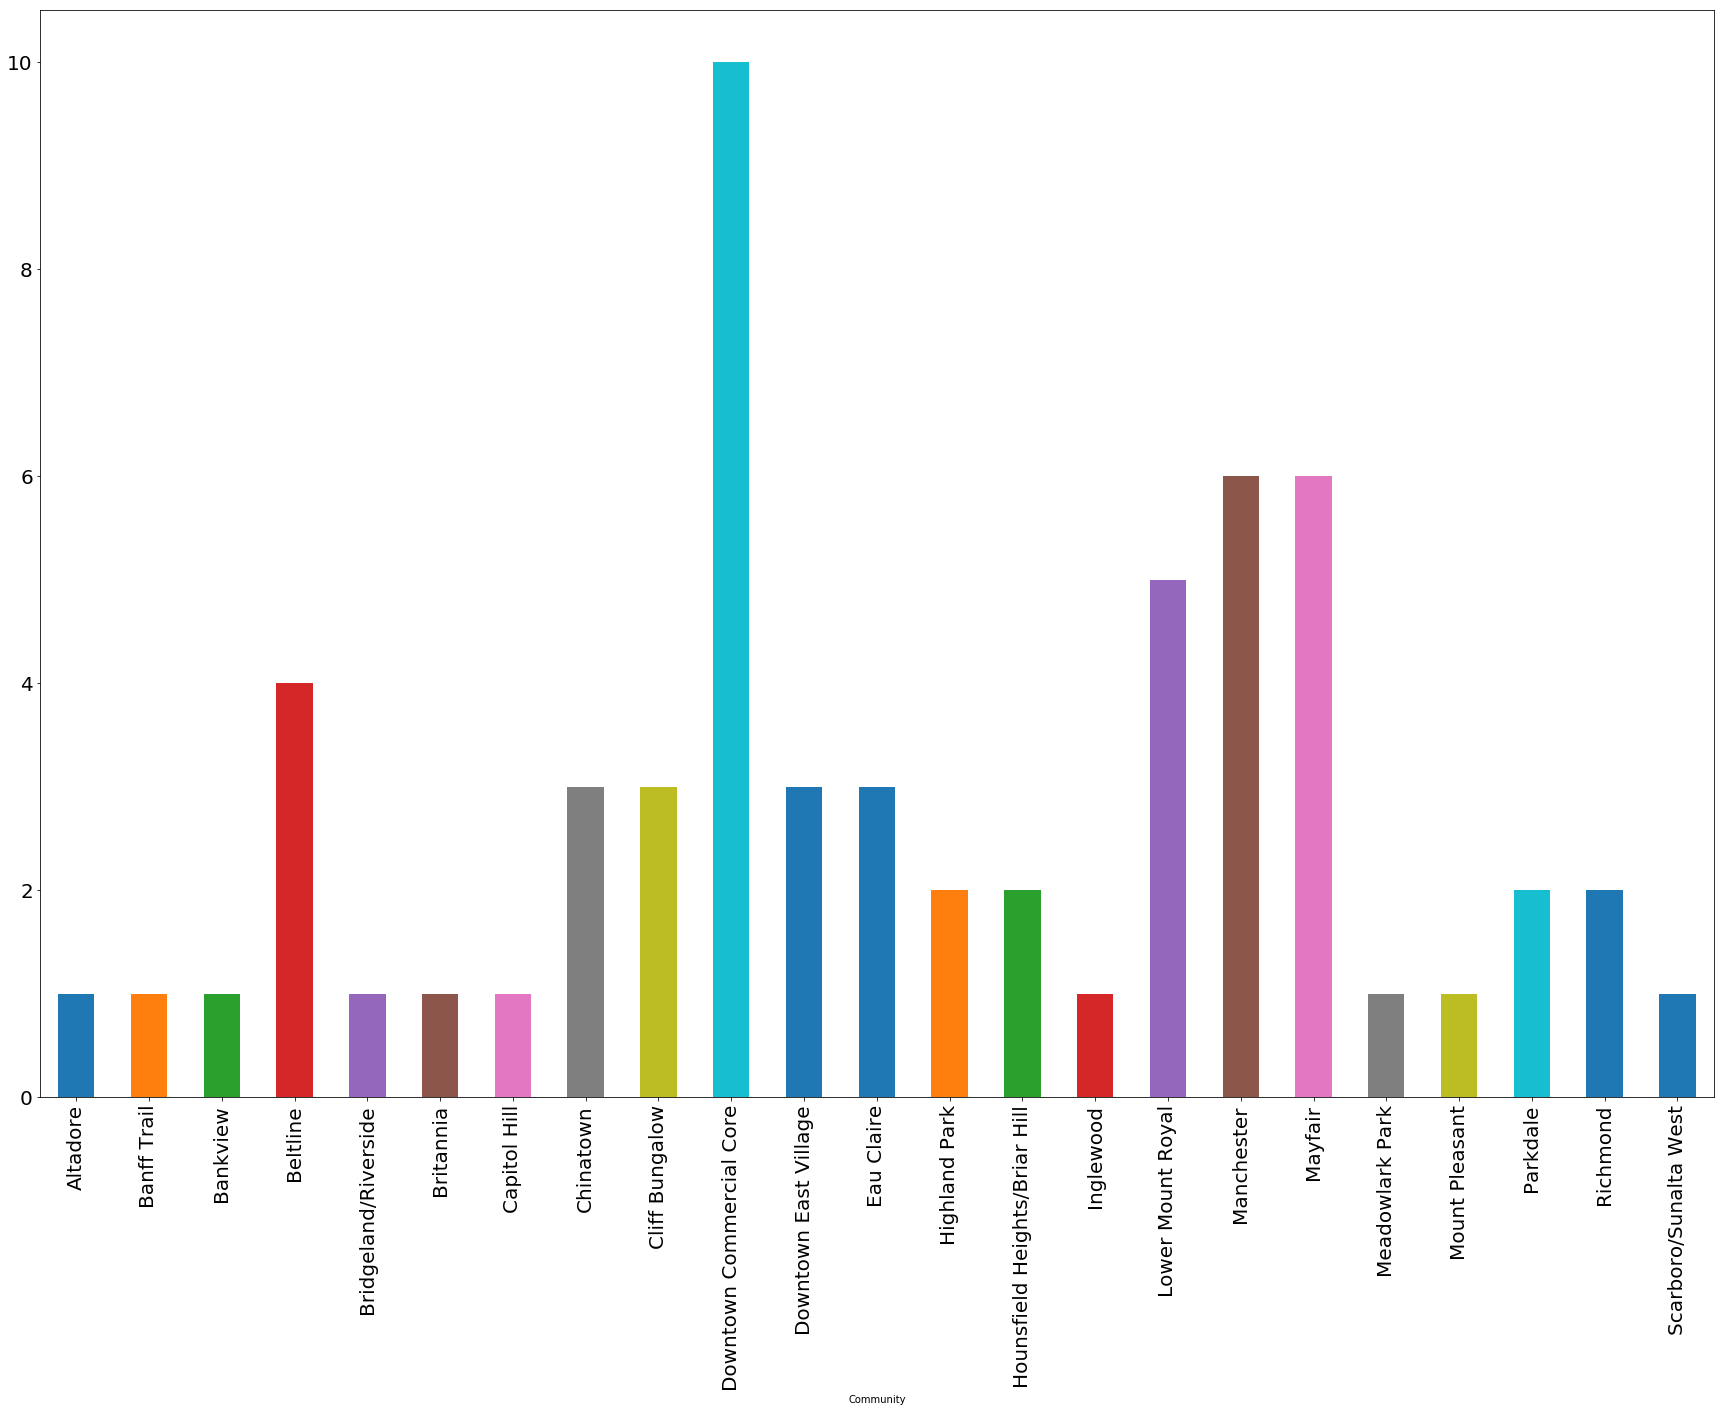

In [28]:
fig=Calgary_cafes.groupby('Community')['Venue'].count().plot(figsize=(30,20), fontsize=20, kind='bar')
fig

And after all, the coffee shops and cafés are the type of venue with the highest number of locations in Calgary

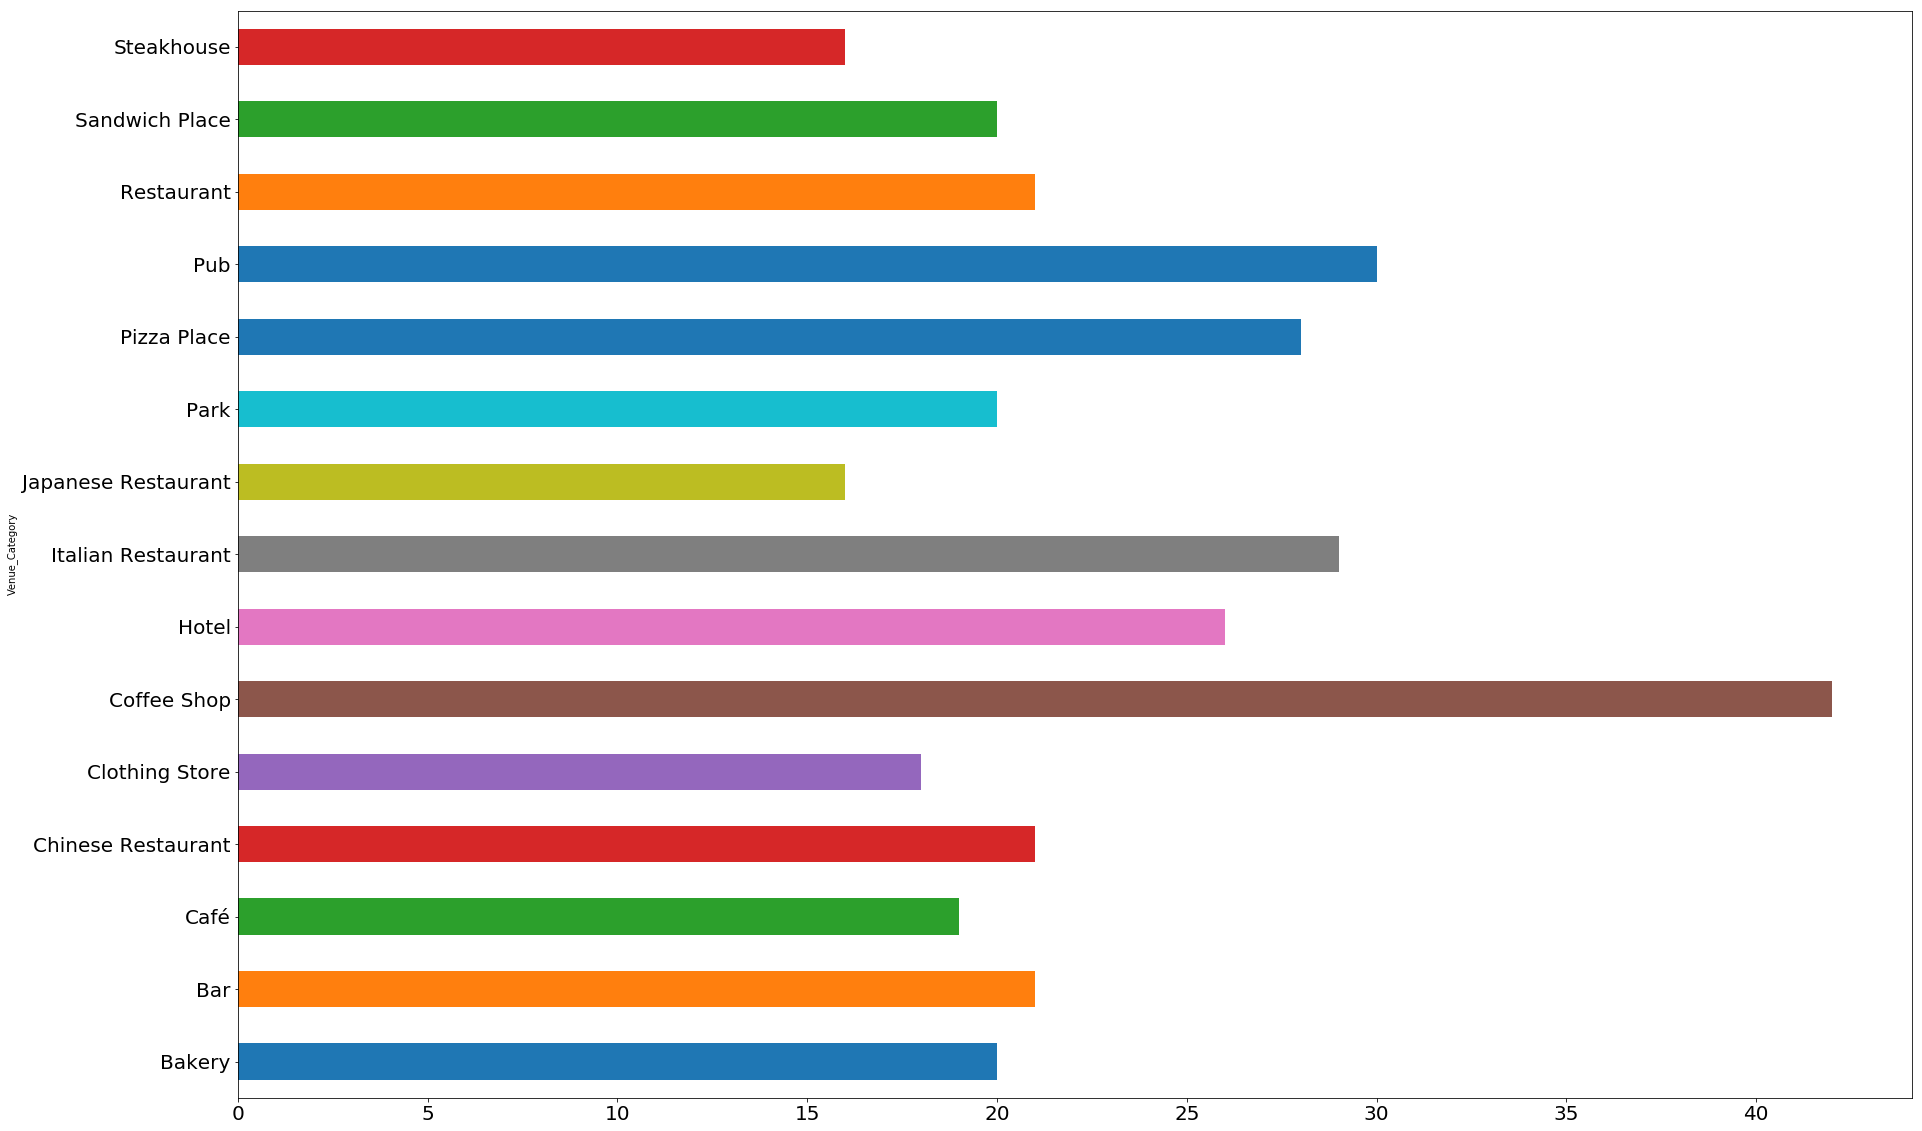

In [29]:
#fig=Calgary_venues.groupby('Venue_Category')['Community'].count().plot(figsize=(30,20), kind='bar')
#Calgary_venues.head()
#import matplotlib.pyplot as plt
Calgary_venues_filtered=Calgary_venues.groupby('Venue_Category').filter(lambda x: x['Venue_Category'].count()>15)
fig=Calgary_venues_filtered.groupby('Venue_Category')['Community'].count().plot(figsize=(30,20), fontsize=20, kind='barh')
#plt.savefig('HorBar')